# Gibanje barže na valu

Prikaz enostavnega gibanja barže na valu. gibanje je omogočeno v dveh prostostnih stopnjah in sicer v smeri:
- **heave** ($z$),
- **pitch** ($\varphi$).

Program sestavljajo trije moduli:
- **geometrija**: manipulacija pozicioniranja barže in vala v prostoru
- **matematičen model**: model gibanja barže kot ODE 2.reda
- **rešitev**: reševanje matematičnega modela s časovnim korakanjem

In [1]:
import time
import math as mat
import numpy as np
from matplotlib import animation, rc
import matplotlib.patches as patch
from IPython.display import HTML

import matplotlib.pyplot as mpl
mpl.rcParams['text.usetex'] = True

## Geometrija

V tem modulu določimo gabaritne točke kvadrata barže. Točke nato premaikamo po $z$ osi in vrtimo okoli težišča $G$.

V drugem delu določimo premico površine vala, kjer poiščemo presečne točke s površino vala in baržo.

In [2]:
# vrne k in n za linearno funkcijo y = k.x + n,
# vhodni parameter sta koordinati dveh točk

def get_lin_func(p1,p2):
    if abs(p1[0] - p2[0]) < 1e-8: 
        k = mat.inf
        n = p1[0]
    else:
        k = (p2[1] - p1[1])/(p2[0] - p1[0])
        n = p1[1] - k*p1[0]
        
    
    return np.array([k,n])

In [3]:
# rotacija robne točke barže P okoli vrtišča/težišča barže G za kot a

def get_rot_pt(P,G,a):
    
    pts = []
    nn = P.shape[0]
    
    for p in P:
        r = p - G
        c = mat.cos(a)
        s = mat.sin(a)

        pts.append(G + np.array([r[0]*c - r[1]*s, r[0]*s + r[1]*c]))
        
    return np.array(pts)

In [4]:
# poišče presečišče dveh premic p1=[k1,n1] in p2=[k2,n2]

def get_cross_pt(l1, l2):
    
    # check for poles
    if l1[0] == mat.inf:
        return np.array([l1[1],l2[0]*l1[1] + l2[1]])
    elif l2[0] == mat.inf:
        return np.array([l2[1],l1[0]*l2[1] + l1[1]])
    else:    
        x = (l1[1] - l2[1])/(l2[0] - l1[0])
        y = l1[0]*x + l1[1]

        return np.array([x,y])

In [5]:
# returns the water level inclination

def wave_inclination(k,zeta0,omega,t,G):
    kW = - k * zeta0 * mat.cos(omega*t - k*G[0])
    
    return kW

In [6]:
# vrne prave koordinate oglišč barže, kjer je koordinatno izhodišče z=0
# težišče barže je od dna barže oddaljeno za Hg
# težišče barže je na višini z
#
# Točke se vrstijo v vrstnem redu:
# levo zgoraj, levo spodaj, desno spodaj, desno zgoraj

def get_barge_corners(L,H,Hg,G):
    
    return np.array([[-L/2,H-Hg],[-L/2,-Hg],[L/2,-Hg],[L/2,H-Hg]]) + G

In [7]:
# Checks if is point p between points p1 and p2

def is_point_in_interval(p,p1,p2):
    
    k = np.array([p2[0]-p1[0],p2[1]-p1[1]])
    k = k/np.linalg.norm(k)
    l = np.dot(p2-p1,k)
    lp = np.dot(p-p1,k)
    # print('int_check: l={}, lp={}'.format(l,lp))
    
    if (lp < l) and (lp > 0):
        return True
    else:
        return False

In [8]:
# Finds intersection point cp between barge side bl and water line wl
# and checks if it is in between barge side points p1 and p2

def check_line_intersection(bl,wl,p1,p2):
    
    # if are parallel
    if np.linalg.norm(bl-wl) < 1e-4:
        # print('1')
        return [True,p1,p2]
    
    cp = get_cross_pt(bl,wl)
    wlY1 = wl[0]*p1[0] + wl[1] 
    wlY2 = wl[0]*p2[0] + wl[1]
        
    if is_point_in_interval(cp,p1,p2):
        if p1[1] > wlY1:
            # print('2:1')
            return [True,cp,p2]
        else:
            # print('2:2')
            return [True,p1,cp]
    else:
        if (p1[1] < wlY1) and (p2[1] < wlY2):
            # print('3:1')
            return [True,p1,p2]
        else:
            # print('3:2')
            return [False,p1,p2]

In [9]:
# set barge underwater polygone

def set_underwater_poly(cpr,bl,wl):
    
    poly = []
    
    [cf,p1,p2] = check_line_intersection(bl[0],wl,cpr[0],cpr[1])
    if cf:
        poly.append(p1)
        poly.append(p2)
    
    [cf,p1,p2] = check_line_intersection(bl[1],wl,cpr[1],cpr[2])
    if cf:
        if len(poly) == 0:
            poly.append(p1)
            poly.append(p2)
        else:
            poly.append(p2)
        
    [cf,p1,p2] = check_line_intersection(bl[2],wl,cpr[2],cpr[3])
    if cf:
        if len(poly) == 0:
            poly.append(p1)
            poly.append(p2)
        else:
            poly.append(p2)
        
    [cf,p1,p2] = check_line_intersection(bl[3],wl,cpr[3],cpr[0])
    if cf:
        poly.append(p1)
        poly.append(p2)
    
    return np.array(poly)

In [10]:
# returns points of barge in motion
# cpr: barge moved and rotated corner points
# cpw: points with water level intersection

def get_barge_position(cp,G,phi,zeta,kW,b):

    cpr = get_rot_pt(cp,G,phi)
    nW = zeta
    wl = [kW, nW]
    
    max_X = np.max(cpr[:,0])
    min_X = np.min(cpr[:,0])
    max_Y = np.max(cpr[:,1])
    min_Y = np.min(cpr[:,1])
    min_YW = np.min([kW * min_X + nW, kW * max_X + nW])
    max_YW = np.max([kW * min_X + nW, kW * max_X + nW])
    
    if min_YW > max_Y:
        return [cpr,cpr,np.array([[-b,-kW*b+nW],[b,kW*b+nW]])]
    elif (max_YW < min_Y):
        return [cpr,np.array([]),np.array([[-b,-kW*b+nW],[b,kW*b+nW]])]
    
    # lines of barge sides
    bl = np.zeros([4,2])
    bl[0] = get_lin_func(cpr[0],cpr[1])
    bl[1] = get_lin_func(cpr[1],cpr[2])
    bl[2] = get_lin_func(cpr[2],cpr[3])
    bl[3] = get_lin_func(cpr[0],cpr[3])
    
    poly = set_underwater_poly(cpr,bl,wl)
    # print('poly:', poly)
    # print('poly_x:', poly[:,0])
    # print('poly_y:', poly[:,1])
    
    return [cpr,poly,np.array([[-b,-kW*b+nW],[b,kW*b+nW]])]

In [11]:
# plots barge with water level

def plot_barge(cpr, poly, wlp, G, phi, alpha, zeta):
    fig, ax = mpl.subplots()
    fig.suptitle(r'$G = [{:.2f},{:.2f}]$, $\phi = {:.1f}^\circ$, $\zeta = {:.2f}$, $\alpha = {:.1f}^\circ$'.format(G[0],G[1],phi*180/mat.pi,zeta,alpha*180/mat.pi))
    
    # barge
    if poly.size != 0:
        ax.fill(poly[:,0],poly[:,1], color='blue', alpha=0.3)
    for i in range(4):
        ax.plot(cpr[i:2+i,0],cpr[i:2+i,1], color='red')
    ax.plot([cpr[0,0],cpr[-1,0]],[cpr[0,1],cpr[-1,1]], color='red')
    ax.plot(G[0],G[1], color='cyan', marker=".", markersize=10)
    
    # water surface level
    ax.plot(wlp[:,0],wlp[:,1], color='blue')
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$z$')
    ax.axis('equal')
    ax.grid()

In [12]:
class UpdatePlot:
    def __init__(self, ax, cp, G, phi, zeta0, k, omega, b, dt=0.01):
        # inital constants 
        self.ax = ax
        self.cp = cp
        self.G = G
        self.phi = phi
        self.wA = zeta0
        self.wK = k
        self.wW = omega
        self.b = b 
        self.dt = dt
        
        # plot parameters
        self.t = 0
        self.xL = b + 1
        self.yL = zeta0 + 2
        
        self.ax.set_xlim((-self.xL, self.xL));
        self.ax.set_ylim((-self.yL, self.yL));
        
        #ratio = 1.0
        #xleft, xright = self.ax.get_xlim()
        #ybottom, ytop = self.ax.get_ylim()
        #rr = abs((ybottom-ytop)/(xright-xleft))*ratio
        #self.ax.set_aspect(rr)
        self.ax.axis('equal')
        self.ax.grid(True)
        
        t = 0
        kW = wave_inclination(self.wK,self.wA,self.wW,t,self.G)
        zeta = self.wA*mat.sin(self.wW*t)
    
        # določanja položaja barže in presečnih točk
        [cpr, poly, wlp] = get_barge_position(self.cp,self.G,self.phi,zeta,kW,self.b)
        
        # wave surface level
        self.x = np.linspace(wlp[0,0], wlp[1,0], 100)
        y = self.wA*np.sin(-self.wK*self.x)
        self.wave, = ax.plot(self.x,y, color='blue')
        #self.wave, = ax.plot(wlp[:,0],wlp[:,1], color='blue')
        
        # barge poly
        bcx = np.zeros(5)
        bcx[0:4] = cpr[:,0]
        bcx[4] = cpr[0,0]
        bcy = np.zeros(5)
        bcy[0:4] = cpr[:,1]
        bcy[4] = cpr[0,1]
    
        self.barge, = ax.plot(bcx,bcy, color='red')
        
        # barge under water poly
        if poly.size != 0:
            self.poly, = ax.fill(poly[:,0],poly[:,1], color='blue', alpha=0.1)

        # time counter
        self.time_text = ax.text(-0.8*self.xL, 0.7*self.yL, '')
        
    def __call__(self, i):
        
        t = self.dt * i
        
        kW = wave_inclination(self.wK,self.wA,self.wW,t,self.G)
        zeta_x0 = self.wA*mat.sin(self.wW*t)
        
        [cpr, poly, wlp] = get_barge_position(self.cp,self.G,self.phi,zeta_x0,kW,self.b)
        
        y = self.wA*np.sin(self.wW*t - self.wK*self.x)
        self.wave.set_data(self.x, y)
        #self.wave.set_data(wlp[:,0],wlp[:,1])
        
        bcx = np.zeros(5)
        bcx[0:4] = cpr[:,0]
        bcx[4] = cpr[0,0]
        bcy = np.zeros(5)
        bcy[0:4] = cpr[:,1]
        bcy[4] = cpr[0,1]
        
        self.barge.set_data(bcx,bcy)
        
        # barge under water poly
        if poly.size != 0:
            self.poly.set_xy(poly)
        else:
            self.poly.set_xy([[0,0],[0,0]])
        
        
        
        self.time_text.set_text('t = {:.1f}s'.format(t))
    
        return (self.barge,self.poly,self.wave,self.time_text,)

### Test modula **Geometrija**

Preverjanje delovanja modula **Geometrija**, da se pravilno določa območje, ki je pod vodno gladino!

In [13]:
# Reference input data

# wave data
la = 100
k = 2*mat.pi/la
zeta0 = 5
T = 10
omega = 2*mat.pi/T

# barge data
L = 10
H = 5
Hg = H/2
G = np.array([2.02,0.25])
phi = 10; phi = phi/180*mat.pi
b = L
cp = get_barge_corners(L, H, Hg, G)

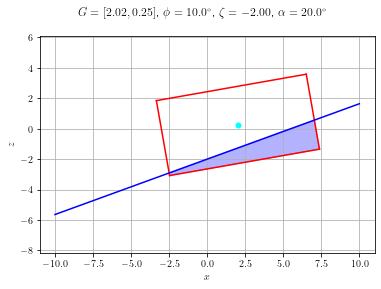

In [14]:
# test single configuration plot

alpha = 20*mat.pi/180
kW = mat.tan(alpha)
zeta = -2

# določanja položaja barže in presečnih točk
[cpr, poly, wlp] = get_barge_position(cp,G,phi,zeta,kW,b)
#print('poly:', poly)
#print('wlp:',wlp)
plot_barge(cpr, poly, wlp, G, phi, mat.atan(kW), zeta)


# frames = 30
wave w = 0.62832 [rad/s]



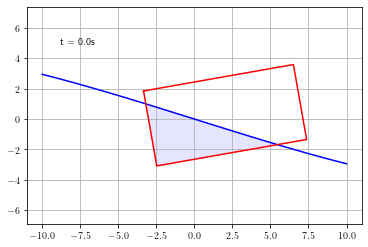

In [15]:
# Test with wave animation on the fixed barge

# animation settings
fs = 3
ff = int(2*mat.pi/omega * fs)

print('# frames = {:d}'.format(ff))
print('wave w = {:.5g} [rad/s]\n'.format(omega))

fig, ax = mpl.subplots()

ppud = UpdatePlot(ax, cp, G, phi, zeta0, k, omega, b, 1/fs)
anim = animation.FuncAnimation(fig, ppud, frames=ff, interval=100, blit=True)

In [16]:
HTML(anim.to_jshtml())

### Matematičen model

Formule za preračun vseh **zunanjih sil** in **zunanjih navorov**, ki delujejo na baržo.

Matematičen model je navadna diferencialna enačba 2.reda

\begin{align*}
\ddot{z} & = f(z,\dot{z},\varphi,\dot{\varphi},t),\\
\ddot{\varphi} & = g(z,\dot{z},\varphi,\dot{\varphi},t), 
\end{align*}

kjer potrebujemo 2 začetna pogoja

\begin{align*}
z(t=0) &= z_0, & \varphi(t=0) &= \varphi_0\\
\dot{z}(t=0) & = v_0, & \dot{\varphi}(t=0) & = \omega_0.\\
\end{align*}

da bi lahko sistem rešili. Zaradi nelinearne narave gibanja, rešujemo sistem numerično z **Runge-Kutta** metodo. 

### Rešitev

Reševanje ODE 2.reda s pomočjo RK metode.